In [1]:
import glob
import random
import os
import sys
import numpy as np
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
import torch
import torch.nn.functional as F

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.nn as nn 

c:\Users\Goncalo\miniconda3\envs\APA2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, img_size=416):
        self.imgs_path = sorted(glob.glob(os.path.join(folder_path, '*.png')), key=len)
        self.img_size  = img_size
    
    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, index):
        # ------------------------------------------------------ #
        # --------------- Write Your Code Here ----------------- #
        # ------------------------------------------------------ #
        img_path = self.imgs_path[index]
        
        img = Image.open(img_path)

        # Extract label
        str = img.filename
        label = str[14:15]
        label = int(label)

        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(img)
        
        
        return img, label

    

In [4]:
dataset = CustomDataset("CropDataset")

num_dataset = len(dataset)
print("Number of images in original  dataset: " + str(num_dataset))
indices = list(range(num_dataset))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 60%/40% for dataset
split = int(np.floor(num_dataset * 0.4)) 
print("Split Number: " + str(split))
training_idx, test_idx = indices[split:], indices[:split] 
print("Number of training images: " + str(len(training_idx)))
print("Number of test images: " + str(len(test_idx)))

# Split 80%/20% for validation
split = int(np.floor(len(training_idx) * 0.2)) 
indices = list(range(len(training_idx)))
training_idx, valid_idx = indices[split:], indices[:split]
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

batch_size = 8
training_loader = torch.utils.data.DataLoader(dataset = dataset, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

valid_loader = torch.utils.data.DataLoader(dataset = dataset, \
                                              batch_size = batch_size, \
                                              sampler = valid_sampler)
                                              

testing_loader = torch.utils.data.DataLoader(dataset = dataset, \
                                             batch_size = batch_size, \
                                             sampler = test_sampler)


Number of images in original  dataset: 2499
Split Number: 999
Number of training images: 1500
Number of test images: 999
Number of training images: 1200
Number of validation images: 300


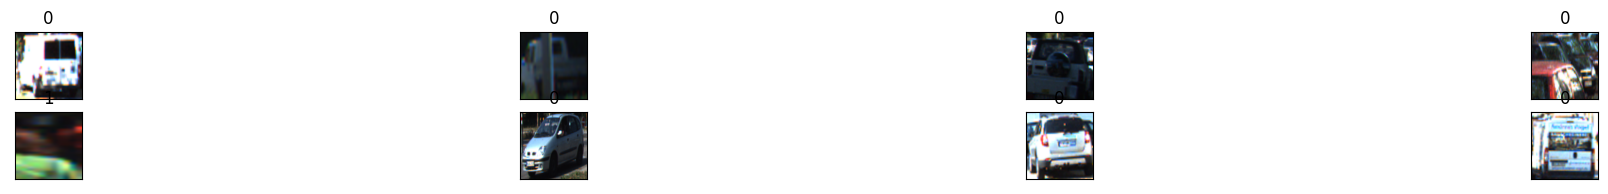

In [5]:
# Visualization of a whole batch
import matplotlib.pyplot as plt

# Get images
dataiter = iter(training_loader)
images, labels = dataiter.next() # Get the images and their labels

# Plot the whole batch 
fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(16)
for idx in np.arange(batch_size):
    #images, labels = training_loader[idx]
    # Add a subplot for the image 
    ax = fig.add_subplot(4, int(batch_size/2), idx+1, xticks=[], yticks=[])
    # Subplot with the image 
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = models.mobilenet_v2(pretrained =True)

for param in cnn_model.parameters():
   param.requires_grad = True 

cnn_model.classifier[1] = nn.Linear(1280, 3)

cnn_model = cnn_model.to(device)
#print(cnn_model)

import torchsummary
print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 64, 64), batch_size = 5) 




Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ConvNormActivation: 2-1                --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─ReLU6: 3-3                        --
|    └─InvertedResidual: 2-2                  --
|    |    └─Sequential: 3-4                   896
|    └─InvertedResidual: 2-3                  --
|    |    └─Sequential: 3-5                   5,136
|    └─InvertedResidual: 2-4                  --
|    |    └─Sequential: 3-6                   8,832
|    └─InvertedResidual: 2-5                  --
|    |    └─Sequential: 3-7                   10,000
|    └─InvertedResidual: 2-6                  --
|    |    └─Sequential: 3-8                   14,848
|    └─InvertedResidual: 2-7                  --
|    |    └─Sequential: 3-9                   14,848
|    └─InvertedResidual: 2-8                  --
|    |    └─Sequential: 3-10             

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ConvNormActivation: 2-1                --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─ReLU6: 3-3                        --
|    └─InvertedResidual: 2-2                  --
|    |    └─Sequential: 3-4                   896
|    └─InvertedResidual: 2-3                  --
|    |    └─Sequential: 3-5                   5,136
|    └─InvertedResidual: 2-4                  --
|    |    └─Sequential: 3-6                   8,832
|    └─InvertedResidual: 2-5                  --
|    |    └─Sequential: 3-7                   10,000
|    └─InvertedResidual: 2-6                  --
|    |    └─Sequential: 3-8                   14,848
|    └─InvertedResidual: 2-7                  --
|    |    └─Sequential: 3-9                   14,848
|    └─InvertedResidual: 2-8                  --
|    |    └─Sequential: 3-10                

(Validation Set) Epoch: 1 Loss: 0.23248433329164983 Acc: 91.0
(Validation Set) Epoch: 2 Loss: 0.14015069057544072 Acc: 96.0
(Validation Set) Epoch: 3 Loss: 0.10258428899454884 Acc: 95.0
(Validation Set) Epoch: 4 Loss: 0.05293673499637104 Acc: 97.66666666666667
(Validation Set) Epoch: 5 Loss: 0.0690014823766675 Acc: 97.66666666666667
(Validation Set) Epoch: 6 Loss: 0.0518422538098821 Acc: 98.0
(Validation Set) Epoch: 7 Loss: 0.06394923201546741 Acc: 98.0
(Validation Set) Epoch: 8 Loss: 0.05113671295887343 Acc: 98.0
(Validation Set) Epoch: 9 Loss: 0.09201543823447234 Acc: 97.33333333333333
(Validation Set) Epoch: 10 Loss: 0.06617594011179184 Acc: 97.66666666666667
(Validation Set) Epoch: 11 Loss: 0.0526593154223095 Acc: 97.66666666666667
(Validation Set) Epoch: 12 Loss: 0.21192949972754832 Acc: 95.66666666666667
(Validation Set) Epoch: 13 Loss: 0.059687031894691246 Acc: 97.66666666666667
(Validation Set) Epoch: 14 Loss: 0.05045748959128408 Acc: 98.0
(Validation Set) Epoch: 15 Loss: 0.081

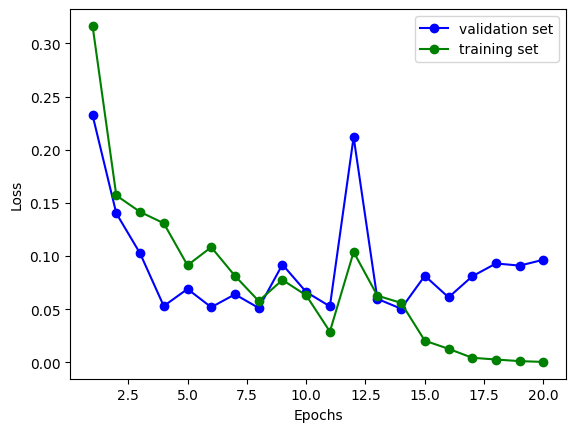

In [7]:
### Training

# Library imports
import torch.optim as optim

# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
lr = 0.0001
num_epochs = 20

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.Adam(cnn_model.parameters(), lr = lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1, verbose=True)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,15,20], gamma=0.1, verbose=True)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)

# Training
running_loss = 0.0
training_loss = 0.0

x = list()
y_valid = list()
y_train = list()

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data

    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()
    

    # Check some statistics
    training_loss += loss.item()
    running_loss += loss.item()
    if batch_id % 1000 == 999: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
      running_loss = 0.0

  y_train.append(training_loss/(len(training_idx)/batch_size))
  training_loss = 0

  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  loss_values = []
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()

      loss_values.append(valid_total_loss)
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/(len(valid_idx)/batch_size)) + " Acc: " + str(100*valid_correct/valid_total))

  # x e y para o plot da loss por epoch
  x.append(epoch+1)
  y_valid.append(valid_total_loss/(len(valid_idx)/batch_size))

  # scheduler.step()
  # scheduler.step(valid_total_loss/len(valid_idx))
  

print("Training is completed!\n")
print(x)
print(y_train)
print(y_valid)
# plot  
plt.plot(x, y_valid, 'bo-', label ='validation set')
plt.plot(x, y_train, 'go-', label ='training set')

plt.xlabel("Epochs")
plt.ylabel("Loss")
  
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score

# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 3
correct = 0
total = 0
total_loss = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]
mean = 0

cnn_model.eval()

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    # -------------------------------------------------------
    # ----------------- Compute metrics here ----------------
    # -------------------------------------------------------

    total += labels.size(0)
    correct += (predicted == labels).sum().item()   
    c = (predicted == labels).squeeze()

    for i in range(len(images)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

    conf_matrix += metrics.confusion_matrix(predicted.cpu(),labels.cpu(), labels = [x for x in range(num_classes)])
    


# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))

mean_class_acc = list()
# Performance per Class
for i in range(num_classes):

    if class_total[i] == 0:
      print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
    else:
      print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))
      mean_class_acc.append(100 * class_correct[i] / class_total[i])


    #mean += (class_correct[i] / class_total[i]) 

#print('Mean Accuracy: %2d %%' % (100*(mean/num_classes)))

mean_class_acc = sum(mean_class_acc) / num_classes
print("Mean-Class Accuracy: " + str(mean_class_acc) + "%")

# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix)

#F1_micro = f1_score(labels.cpu(), predicted.cpu(), average='micro')
F1_mean = f1_score(labels.cpu(), predicted.cpu(), average='weighted', labels=np.unique(predicted.cpu()))
#print("Global F1 Score: " + str(F1_micro*100))
print("Media de F1 Score das classes: " + str(F1_mean*100))

Prec = precision_score(labels.cpu(), predicted.cpu(), average="weighted", labels=np.unique(predicted.cpu()))
Rec = recall_score(labels.cpu(), predicted.cpu(), average="weighted", labels=np.unique(predicted.cpu())) 
print("Precision: " + str(Prec*100))
print("Recall: " + str(Rec*100))

Accuracy using 999 test images: 97.5975975975976 %

Accuracy of  0 : 99 % in 832 Images
Accuracy of  1 : 91 % in 121 Images
Accuracy of  2 : 80 % in 46 Images
Mean-Class Accuracy: 90.5231194201056%

Confusion Matrix
[[827   8   4]
 [  3 111   5]
 [  2   2  37]]
Media de F1 Score das classes: 100.0
Precision: 100.0
Recall: 100.0
